In [1]:
import os

os.chdir('../..')
print("Current working directory:", os.getcwd())

Current working directory: /dmj/fizmed/kchorzela/licencjat/eeg-site-effects


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging

from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score
from models.gbe_class import GBE
from catboost import CatBoostClassifier, metrics
from sklearn.preprocessing import LabelEncoder
from old.harmonization import SiteWiseStandardScaler
from sklearn.decomposition import PCA


In [3]:
ELM19_info_filtered_path = 'datasets/ELM19/filtered/ELM19_info_filtered.csv'
ELM19_features_filtered_path = 'datasets/ELM19/filtered/ELM19_features_filtered.csv'

In [4]:
df_info = pd.read_csv(ELM19_info_filtered_path)
df_feats = pd.read_csv(ELM19_features_filtered_path)

In [5]:
df_info.loc[:, 'cls_bin'] = np.where(df_info.loc[:, 'classification'] == 'patho', 1, 0)

In [6]:
X = df_feats
y = df_info['cls_bin']
groups = df_info['institution_id']

In [7]:
label_encoder = LabelEncoder()
df_info['institution_id_encoded'] = label_encoder.fit_transform(df_info['institution_id'])

covars = pd.DataFrame()
covars['batch'] = df_info['institution_id']
covars['gender'] = (df_info['patient_sex'] == 'Male').astype(int)
covars['age'] = df_info['age_dec']

In [8]:
def get_scores(y_true, y_prob, th=0.5):
    y_pred = y_prob > th
    
    mcc = matthews_corrcoef(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_prob)
    
    return mcc, acc, precision, recall, f1, auc

In [9]:
params = {'iterations': 700,
          'learning_rate': 0.08519504279364008,
          'depth': 6.0,
          'l2_leaf_reg': 1.1029971156522604,
          'colsample_bylevel': 0.019946626267165004,
          'objective': 'Logloss',
          'thread_count': -1, 
          'boosting_type': 'Plain', 
          'bootstrap_type': 'MVS',
          'eval_metric': metrics.AUC(),
          'allow_writing_files': False,
          }

In [ ]:
logo = LeaveOneGroupOut()
K = 30
results = []
for train_idx, site_idx in logo.split(X, y, groups):
    logging.info("Initializing the GBE model...")
    gbe = GBE(esize=30, fun_model=CatBoostClassifier, **params)
    
    hospital_test = df_info['institution_id'].iloc[site_idx].unique()[0]

    # Split data
    X_train, X_site = X.iloc[train_idx], X.iloc[site_idx]
    y_train, y_site = y.iloc[train_idx], y.iloc[site_idx]
    covars_train, covars_site = covars.iloc[train_idx], covars.iloc[site_idx]

    # Calibration from normal samples
    norm_mask_site = df_info['classification'].iloc[site_idx] == 'norm'
    X_site_norm = X_site[norm_mask_site]
    y_site_norm = y_site[norm_mask_site]
    covars_site_norm = covars_site[norm_mask_site]
    
    X_calib, X_test_norm, y_calib, y_test_norm, covars_calib, covars_test_norm = train_test_split(
        X_site_norm,
        y_site_norm,
        covars_site_norm,
        train_size=K,
        random_state=100
    )

    # Full test set (remaining norm + pathological)
    X_test_full = pd.concat([X_test_norm, X_site[~norm_mask_site]])
    y_test_full = pd.concat([y_test_norm, y_site[~norm_mask_site]])
    covars_test_full = pd.concat([covars_test_norm, covars_site[~norm_mask_site]])

    # ComBat fit only on train_norm + calib
    train_norm_mask = (df_info.index.isin(train_idx)) & (df_info['classification'] == 'norm')
    X_train_norm = X.loc[train_norm_mask]
    y_train_norm = y.loc[train_norm_mask]
    covars_train_norm = covars.loc[train_norm_mask]

    X_fit = pd.concat([X_train_norm, X_calib], axis=0)
    covars_fit = pd.concat([covars_train_norm, covars_calib])

    pca = PCA(n_components=200, svd_solver='full', random_state=100)
    X_fit_pca = pca.fit_transform(X_fit)
    X_test_pca = pca.transform(X_test_full)
    X_train_pca = pca.transform(X_train)
    
    #combat = CombatModel()
    #combat.fit(
    #    X_fit_pca, 
    #    covars_fit[['batch']].to_numpy(), 
    #    covars_fit[['gender']].to_numpy(), 
    #    covars_fit[['age']].to_numpy()
    #)

    # scaler = SiteWiseStandardScaler().fit(X_fit, covars_fit['batch'])
    # X_train_harmonized = scaler.transform(X_train, covars_train['batch'])
    # X_test_harmonized = scaler.transform(X_test_full, covars_test_full['batch'])
    
    X_train_harmonized = X_train_pca #combat.transform(
    #     X_train_pca, 
    #     covars_train[['batch']].to_numpy(), 
    #     covars_train[['gender']].to_numpy(), 
    #     covars_train[['age']].to_numpy()
    # )
    
    X_test_harmonized = X_test_pca #combat.transform(
    #     X_test_pca, 
    #     covars_test_full[['batch']].to_numpy(), 
    #     covars_test_full[['gender']].to_numpy(), 
    #     covars_test_full[['age']].to_numpy()
    # )

    
    logging.info(f"Starting validation for hospital: {hospital_test}")
    
    logging.info("Training the model...")
    gbe.fit(X_train_harmonized, y_train, verbose=False)
    logging.info("Model training completed.")
    
    logging.info("Generating predictions...")
    y_prob = gbe.predict_proba(X_test_harmonized)[:, 1]
    logging.info("Predictions generated successfully.")

    mcc, acc, precision, recall, f1, auc = get_scores(y_test_full, y_prob)
    logging.info(f"Calculated metrics - ACC: {acc:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}, AUC: {auc:.2f}, MCC: {mcc:.2f}")
    
    results.append({
        'Hospital': hospital_test,
        'Accuracy': acc,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'MCC': mcc
    })
    logging.info(f"Results saved for hospital: {hospital_test}")

results_df = pd.DataFrame(results)

In [11]:
results_df.to_csv("results/tables/harmonization/raw/logo_calibration_30_pca_200_results.csv",  index=False)

In [28]:
def stratified_site_folds(df_info, n_splits=5, seed=42):
    """
    Tworzy foldy, w których każdy fold zawiera dane z każdego SITE,
    a podział wewnątrz SITE jest losowy.

    Zwraca listę (train_idx, test_idx) dla każdego folda.
    """
    np.random.seed(seed)
    site_ids = df_info['institution_id'].unique()
    indices_per_site = {
        site: df_info[df_info['institution_id'] == site].index.values
        for site in site_ids
    }

    # Losowy podział każdego SITE na foldy
    site_folds = {site: np.array_split(np.random.permutation(idxs), n_splits)
                  for site, idxs in indices_per_site.items()}

    folds = []
    for fold_idx in range(n_splits):
        test_indices = []
        for site in site_ids:
            test_indices.extend(site_folds[site][fold_idx])
        test_indices = np.array(test_indices)

        train_indices = df_info.index.difference(test_indices)
        folds.append((train_indices.to_numpy(), test_indices))

    return folds

In [31]:
kf[0]

(array([    0,     1,     2, ..., 54776, 54777, 54778]),
 array([22208, 22287, 22211, ..., 54007, 52592, 53044]))

In [11]:
kf = stratified_site_folds(df_info, n_splits=5)

results = []
for fold, (train_idx, test_idx) in enumerate(kf):
    logging.info("Initializing the GBE model...")
    gbe = GBE(esize=30, fun_model=CatBoostClassifier, **params)
        
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    covars_train, covars_test = covars.iloc[train_idx], covars.iloc[test_idx]
    
    train_mask = df_info.index.isin(train_idx)
    norm_mask = df_info['classification'] == 'norm'
    train_norm_mask = train_mask & norm_mask

    X_train_norm = X[train_norm_mask]
    covars_train_norm = covars[train_norm_mask]
    
    #combat = CombatModel().fit(X_train_norm_pca, covars_train_norm[['batch']].to_numpy(), covars_train_norm[['gender']].to_numpy(), covars_train_norm[['age']].to_numpy())
    #X_train_harmonized = combat.transform(X_train_pca, covars_train[['batch']].to_numpy(), covars_train[['gender']].to_numpy(), covars_train[['age']].to_numpy())
    #X_test_harmonized = combat.transform(X_test_pca, covars_test[['batch']].to_numpy(), covars_test[['gender']].to_numpy(), covars_test[['age']].to_numpy())

    scaler = SiteWiseStandardScaler().fit(X_train_norm, covars_train_norm['batch'])
    X_train_harmonized = scaler.transform(X_train, covars_train['batch'])
    X_test_harmonized = scaler.transform(X_test, covars_test['batch'])
    
    logging.info("Training the model...")
    gbe.fit(X_train_harmonized, y_train, verbose=False)
    logging.info("Model training completed.")
    
    logging.info("Generating predictions...")
    y_prob = gbe.predict_proba(X_test_harmonized)[:, 1]
    logging.info("Predictions generated successfully.")

    mcc, acc, precision, recall, f1, auc = get_scores(y_test, y_prob)
    logging.info(f"Calculated metrics - ACC: {acc:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}, AUC: {auc:.5f}, MCC: {mcc:.2f}")
    
    results.append({
        'Accuracy': acc,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'MCC': mcc
    })

results_df = pd.DataFrame(results)

2025-09-02 19:58:46,490 - INFO - Initializing the GBE model...
2025-09-02 19:58:46,491 - INFO - Initializing 30 models in the ensemble.
2025-09-02 19:58:46,492 - INFO - Initialized 30 models in the ensemble.
2025-09-02 19:58:51,687 - INFO - Training the model...
2025-09-02 19:58:51,688 - INFO - Training model 1/30...
2025-09-02 19:59:05,705 - INFO - Model 1/30 trained successfully.
2025-09-02 19:59:05,706 - INFO - Training model 2/30...
2025-09-02 19:59:19,741 - INFO - Model 2/30 trained successfully.
2025-09-02 19:59:19,742 - INFO - Training model 3/30...
2025-09-02 19:59:33,770 - INFO - Model 3/30 trained successfully.
2025-09-02 19:59:33,771 - INFO - Training model 4/30...
2025-09-02 19:59:47,733 - INFO - Model 4/30 trained successfully.
2025-09-02 19:59:47,734 - INFO - Training model 5/30...
2025-09-02 20:00:01,685 - INFO - Model 5/30 trained successfully.
2025-09-02 20:00:01,686 - INFO - Training model 6/30...
2025-09-02 20:00:15,386 - INFO - Model 6/30 trained successfully.
2025-

In [12]:
results_df.to_csv("results/tables/stratified_cv_standard_scalar.csv",  index=False)

# Results Analysis

## LOGO

In [3]:
df_unharmonized = pd.read_csv("results/tables/harmonization/raw/logo_calibration_30_results.csv")
df_combat = pd.read_csv("results/tables/harmonization/combat/logo_calibration_30_results.csv")
df_scaler = pd.read_csv("results/tables/harmonization/standard_scaler/logo_calibration_30_results.csv")

In [4]:
df_unharmonized['AUC'].mean(), df_scaler['AUC'].mean(), df_combat['AUC'].mean()

(0.8040477289595162, 0.8126091087813029, 0.8126912897003649)

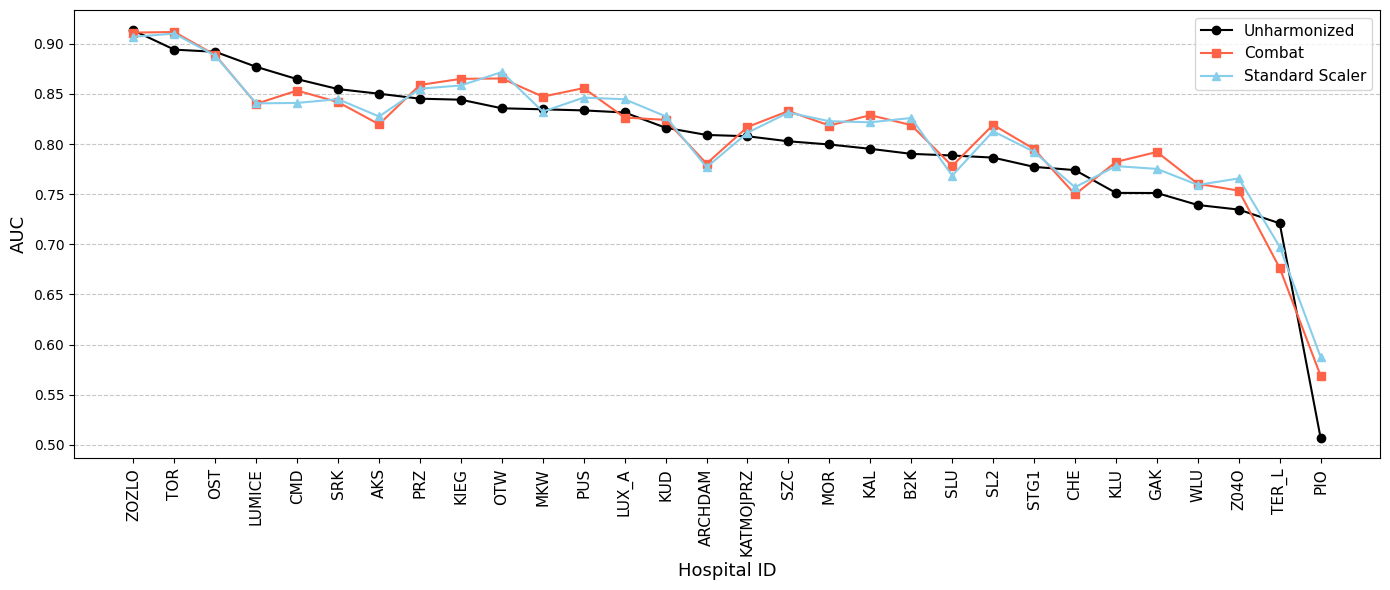

In [5]:
metric = "AUC"

sort_idx = df_unharmonized[metric].values.argsort()[::-1]
class_labels_sorted = df_unharmonized['Hospital'][sort_idx]
unharmonized_auc = df_unharmonized[metric].values[sort_idx]
combat_auc = df_combat[metric].values[sort_idx]
standard_scaler_auc = df_scaler[metric].values[sort_idx]

plt.figure(figsize=(14, 6))
plt.plot(class_labels_sorted, unharmonized_auc, marker='o', linestyle='-', color='black', label='Unharmonized')
plt.plot(class_labels_sorted, combat_auc, marker='s', linestyle='-', color='tomato', label='Combat')
plt.plot(class_labels_sorted, standard_scaler_auc, marker='^', linestyle='-', color='skyblue', label='Standard Scaler')


plt.ylabel("AUC", fontsize=13)
plt.xlabel("Hospital ID", fontsize=13)
plt.xticks(rotation=90, fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='upper right', fontsize=11)
#plt.title("Average MCC by Hospital — Impact of Feature Harmonization", fontsize=16, weight='bold')
plt.tight_layout()

plt.savefig('results/figures/harmonization/LOGO_harmonization_results_AUC.png', dpi=300)
plt.show()

# CV5

In [14]:
df_unharmonized = pd.read_csv("results/tables/stratified_cv_unharmonized.csv")
df_combat = pd.read_csv("results/tables/stratified_cv_combat.csv")
df_scaler = pd.read_csv("results/tables/stratified_cv_standard_scalar.csv")

In [27]:
df_scaler

,Accuracy,Precision,Recall,F1-Score,AUC,MCC,Harmonization
0,0.796480,0.820565,0.779141,0.799317,0.877317,0.593979,Standard Scaler
1,0.796825,0.806616,0.792359,0.799424,0.878177,0.593712,Standard Scaler
2,0.792096,0.807345,0.779996,0.793435,0.875491,0.584652,Standard Scaler
3,0.792511,0.808950,0.783201,0.795867,0.877370,0.585339,Standard Scaler
4,0.801444,0.822185,0.784435,0.802867,0.883913,0.603765,Standard Scaler


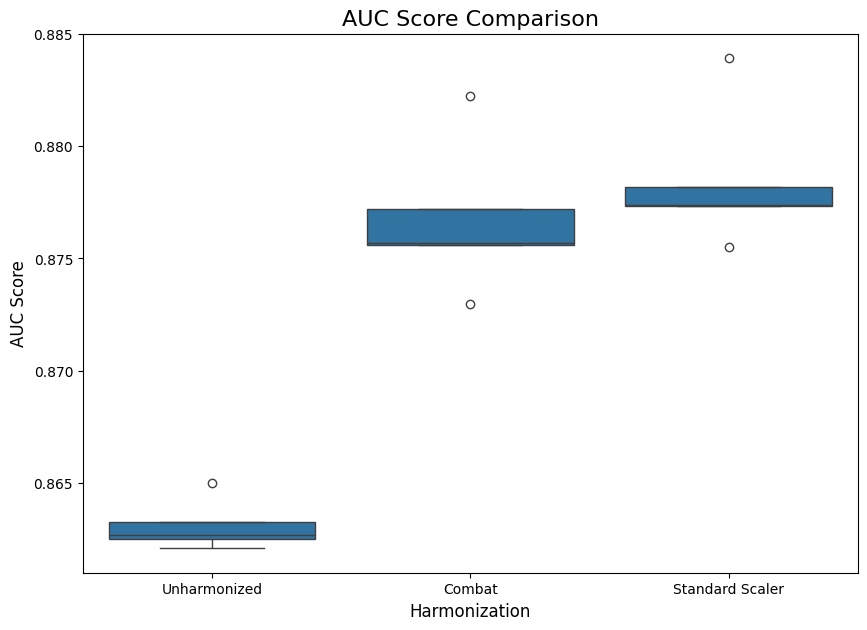

In [23]:
df_unharmonized['Harmonization'] = 'Unharmonized'
df_combat['Harmonization'] = 'Combat'
df_scaler['Harmonization'] = 'Standard Scaler'

plot_df = pd.concat([df_unharmonized, df_combat, df_scaler])


fig = plt.figure(figsize=(10, 7))  # Set the figure size

sns.boxplot(data=plot_df, x='Harmonization', y='AUC')

plt.title('AUC Score Comparison', fontsize=16)
plt.xlabel('Harmonization', fontsize=12)
plt.ylabel('AUC Score', fontsize=12)
#plt.ylim(0.8,1)
plt.show()